# LIBRERIE NECESSARIE ALL'UTILIZZO

In [1]:
import cv2
import json
import numpy as np
# Verifica se OpenCV è correttamente installato
print(cv2.__version__)
import matplotlib.pyplot as plt
import geojson
from shapely.geometry import Polygon, mapping
# import os
# import torch

def plt_image(image):
    
    # Controlla se l'immagine è stata caricata correttamente
    if image is not None:
        # Converti l'immagine da BGR a RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Mostra l'immagine con Matplotlib
        plt.imshow(image)
        plt.axis('off')  # Nasconde gli assi
        plt.title("Immagine caricata")  # Aggiungi un titolo se desiderato
        plt.show()  # Visualizza l'immagine
    else:
        print("Errore nel caricamento dell'immagine")


4.10.0


Immagine caricata correttamente


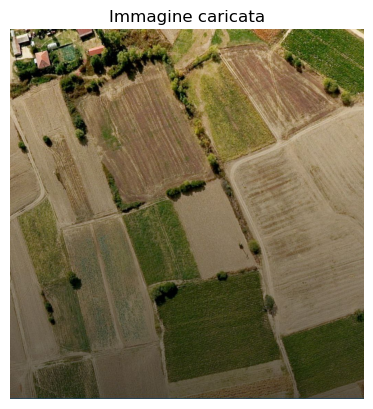

In [2]:
file_path_image = "image/photo_2024-09-20_16-00-22.jpg"
file_path_image_w_ext = file_path_image.split('.')[0]

# Test di lettura di un'immagine
image = cv2.imread(file_path_image)
if image is not None:
    print("Immagine caricata correttamente")
else:
    print("Errore nel caricamento dell'immagine")

plt_image(image)


In [3]:
from segment_anything import sam_model_registry

# Aprire e leggere un file locale
model='vit_h'
file_path = "model/sam_vit_h_4b8939.pth"

print(f"Modello '{model}'. Creazione del modello...")
# Utilizza il contesto "with" per aprire e leggere il file
with open(file_path, 'r') as file:
    sam = sam_model_registry[model](checkpoint=file_path)
    sam.to(device='cuda')
    # predictor = SamPredictor(sam)
    
# predictor.set_image(image)
# image_embedding = predictor.get_image_embedding().cpu().numpy()
# np.save(file_path_image_w_ext+"_embedding.npy", image_embedding)

Modello 'vit_h'. Creazione del modello...


In [4]:
from segment_anything import SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)
print(f"Mask Generator. Creazione masks...")
masks = mask_generator.generate(image)
print("Sono stati identificati ",len(masks),"oggetti")

Mask Generator. Creazione masks...
Sono stati identificati  98 oggetti


In [5]:
def disegna_maschera_in_rosso(masks,image):

    # Crea un'immagine vuota per la maschera
    mask_overlay = np.zeros_like(image)

    # Sovrapponi ogni maschera sull'immagine vuota
    for mask in masks:
        mask_array = mask['segmentation']  # Ottieni la maschera di segmentazione
        mask_overlay[mask_array] = [255, 0, 0]  # Colore rosso per la maschera

    # Combina l'immagine originale e la maschera
    combined_image = cv2.addWeighted(image, 0.7, mask_overlay, 0.3, 0)
    return combined_image

def disegna_contorini_in_nero(image):
    # Crea una copia dell'immagine per disegnare i contorni
    image_with_contours = image.copy()

    # Sovrapponi i contorni per ogni maschera
    for mask in masks:
        mask_array = mask['segmentation']  # Ottieni la maschera di segmentazione

        # Trova i contorni della maschera
        contours, _ = cv2.findContours(mask_array.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Disegna i contorni neri
        cv2.drawContours(image_with_contours, contours, -1, (0, 0, 0), thickness=5)  # Spessore 5 per contorni bold
    return image_with_contours

def disegna_cerchi(image,masks):
    image_with_circles = image.copy()
    for mask in masks:
        mask_array = mask['segmentation']  # Ottieni la maschera di segmentazione

        # Trova i contorni della maschera
        contours, _ = cv2.findContours(mask_array.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            # Calcola il momento del contorno per trovare il centro
            M = cv2.moments(contour)
            if M['m00'] != 0:
                cX = int(M['m10'] / M['m00'])
                cY = int(M['m01'] / M['m00'])
                radius = 10  # Imposta il raggio del cerchio
                cv2.circle(image_with_circles, (cX, cY), radius, (255, 0, 0), 2)  # Disegna il cerchio rosso
    return image_with_circles

def disegna_rettangoli(image,masks):
    image_with_boxes = image.copy()
    for mask in masks:
        mask_array = mask['segmentation']  # Ottieni la maschera di segmentazione

        # Trova i contorni della maschera
        contours, _ = cv2.findContours(mask_array.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Disegna un rettangolo attorno a ciascun contorno
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)  # Ottieni la bounding box del contorno
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Disegna il rettangolo rosso
    return image_with_boxes

# Carica l'immagine originale
image = cv2.imread(file_path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR a RGB

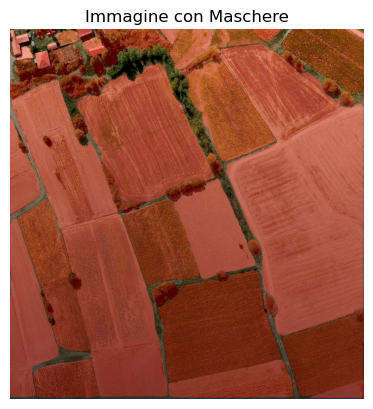

In [6]:
combined_image = disegna_maschera_in_rosso(masks,image)
# Mostra l'immagine combinata
plt.imshow(combined_image)
plt.axis('off')  # Nasconde gli assi
plt.title("Immagine con Maschere")
plt.show()

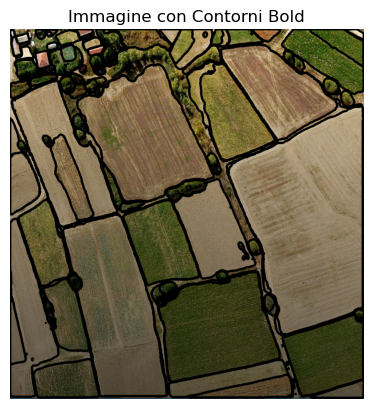

In [7]:
image_with_contours=disegna_contorini_in_nero(image)
# Mostra l'immagine con i contorni
plt.imshow(image_with_contours)
plt.axis('off')  # Nasconde gli assi
plt.title("Immagine con Contorni Bold")
plt.show()


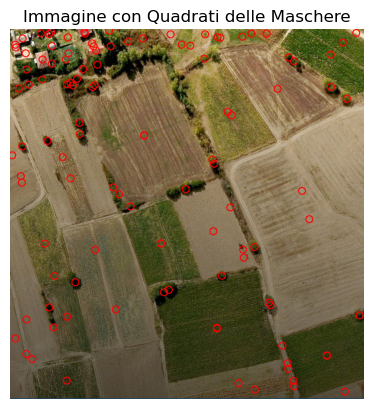

In [8]:
image_with_circles=disegna_cerchi(image,masks)
plt.imshow(image_with_circles)
plt.axis('off')  # Nasconde gli assi
plt.title("Immagine con Quadrati delle Maschere")
plt.show()

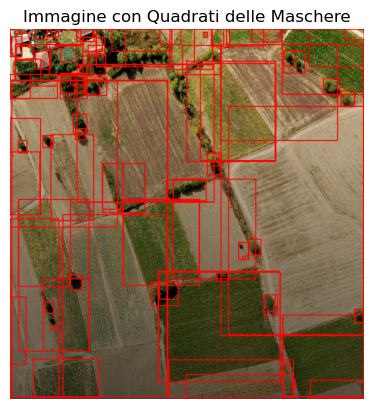

In [9]:
image_with_boxes=disegna_rettangoli(image,masks)
# Mostra l'immagine con i quadrati
plt.imshow(image_with_boxes)
plt.axis('off')  # Nasconde gli assi
plt.title("Immagine con Quadrati delle Maschere")
plt.show()

## Aggiunta del processo di rimozione delle strisce dai bordi

In [10]:
# Aggiungi qui il processo di rimozione delle strisce dai bordi
def apply_morphological_smoothing(image):
    # Dividi l'immagine nei tre canali B, G e R
    channels = cv2.split(image)

    # Definisci un kernel per le operazioni morfologiche
    kernel = np.ones((7,7), np.uint8)

    smoothed_channels = []
    for channel in channels:
        # Applica una chiusura morfologica e dilatazione su ciascun canale
        closing = cv2.morphologyEx(channel, cv2.MORPH_CLOSE, kernel)
        dilated = cv2.dilate(closing, kernel, iterations=1)

        # Applica una sfocatura gaussiana per un effetto di smoothing
        smoothed_channel = cv2.GaussianBlur(dilated, (5, 5), 0)

        smoothed_channels.append(smoothed_channel)

    # Ricombina i canali B, G e R in un'unica immagine
    smoothed_image = cv2.merge(smoothed_channels)

    return smoothed_image

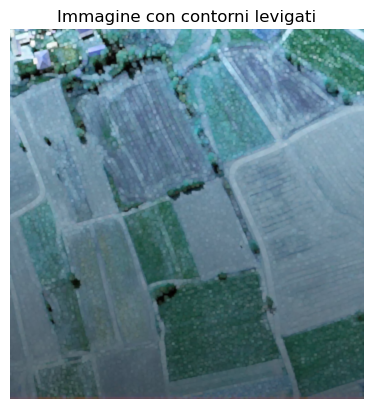

L'immagine ha la seguente shape: (1073, 1026, 3)


In [12]:
# Applica il processo di smoothing all'immagine originale
image = cv2.imread(file_path_image)
smoothed_image = apply_morphological_smoothing(image)

# Mostra l'immagine risultante con contorni levigati
plt.imshow(smoothed_image)
plt.axis('off')  # Nasconde gli assi
plt.title("Immagine con contorni levigati")
plt.show()

# Salva l'immagine risultante
# cv2.imwrite(file_path_image_w_ext + "_smoothed.png", smoothed_image)
# print(f"Immagine levigata salvata come {file_path_image_w_ext}_smoothed.png")
print("L'immagine ha la seguente shape:",smoothed_image.shape)  # Controlla il tipo di dato

In [13]:
new_masks = mask_generator.generate(smoothed_image)
print("Sono stati identificati ",len(new_masks),"oggetti, a seguito della levigazione dell'immagine.")

Sono stati identificati  74 oggetti, a seguito della levigazione dell'immagine.


In [14]:
masks=new_masks

---
# Salvataggio della maschera in file json con coordinate x e y

In [15]:
# Supponiamo che 'masks' sia una lista di dizionari contenente le segmentazioni
# Ciascun dizionario ha una chiave 'segmentation' con la maschera come array numpy

def save_masks(masks,SAVE = True,json_path="results_json/contour_mask_data.json"):
    contours_list = []

    # 2. Estrai le coordinate dei pixel dei contorni
    for mask in masks:
        mask_array = mask['segmentation']
        
        # Assicurati che la maschera sia binaria (0 e 255)
        mask_array = mask_array.astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        contour_list = []
        for contour in contours:
            contour_pixels = contour[:, 0, :].tolist()  # Estrai solo le coordinate X, Y dei pixel
            contour_list.append(contour_pixels)
        contours_list.append({"contour": contour_list})

    # 3. Crea un dizionario per contenere i dati dei contorni
    masks_data = {
        "contours": contours_list
    }

    # 4. Opzione per salvare i dati in un file JSON
    if SAVE:
        # 5. Salva i dati in un file JSON
        with open(json_path, "w") as json_file:
            json.dump(masks_data, json_file, indent=4)
        
        print(f"File JSON salvato come {json_path}")
    return masks_data

masks_data=save_masks(masks)


File JSON salvato come results_json/contour_mask_data.json


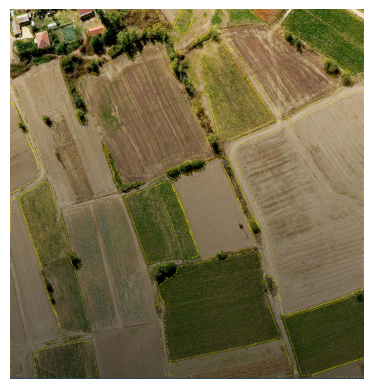

In [16]:
def color_pixels_yellow(image, masks_data):
    # Copia l'immagine originale per modificarla
    modified_image = image.copy()

    # Itera su ogni contorno in masks_data
    for mask in masks_data['contours']:
        for contour in mask['contour']:
            # Ogni contorno è una lista di coordinate (X, Y)
            for point in contour:
                x, y = point
                # Imposta il pixel corrispondente a nero (0 per scala di grigi, [0, 0, 0] per colore)
                if len(modified_image.shape) == 2:  # Immagine in scala di grigi
                    modified_image[y, x] = 0
                elif len(modified_image.shape) == 3:  # Immagine a colori
                    modified_image[y, x] = [255, 255, 0]
    
    return modified_image

# Carica l'immagine (può essere in scala di grigi o a colori)
image = cv2.imread(file_path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Applica il metodo per colorare i pixel in nero basato su masks_data
modified_image = color_pixels_yellow(image, masks_data)

# Salva o mostra l'immagine modificata
# cv2.imwrite('path_to_save_modified_image.png', modified_image)
plt.imshow(modified_image)
plt.axis('off')  # Nasconde gli assi
plt.show()

---
# Salvataggio della maschera in file geojson

GeoJSON salvato in: results_json/output_masks.geojson


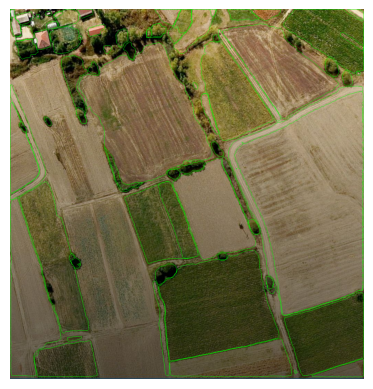

In [17]:
def masks_to_geojson(masks,SAVE = True,output_geojson_path="results_json/output_masks.geojson"):
    features = []

    # Itera su ogni maschera in masks
    for mask in masks:
        # Estrai l'array di segmentazione dalla maschera
        mask_array = mask['segmentation']
        
        # Assicurati che la maschera sia binaria (0 e 255)
        mask_array = mask_array.astype(np.uint8) * 255
        
        # Trova i contorni della maschera
        contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Itera su ogni contorno trovato
        for contour in contours:
            # Converti il contorno in un poligono
            contour_list = contour[:, 0, :].tolist()  # Converti le coordinate del contorno in una lista
            if len(contour_list) >= 3:  # I poligoni devono avere almeno 3 punti
                polygon = Polygon(contour_list)
                
                # Crea una feature GeoJSON per il poligono
                feature = geojson.Feature(geometry=mapping(polygon), properties={})
                features.append(feature)

    # Crea la FeatureCollection GeoJSON
    feature_collection = geojson.FeatureCollection(features)

    # Salva il GeoJSON in un file
    with open(output_geojson_path, "w") as f:
        # geojson.dump(feature_collection, f)
        json.dump(feature_collection, f, indent=4)

    print(f"GeoJSON salvato in: {output_geojson_path}")

def plot_geojson_contours_on_image(image_path, geojson_path='results_json/output_masks.geojson'):
    # 1. Carica l'immagine
    image = cv2.imread(image_path)
    
    # 2. Carica il file GeoJSON
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)
    
    # 3. Estrai i contorni dai poligoni GeoJSON
    for feature in geojson_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            for polygon in feature['geometry']['coordinates']:
                # Converti le coordinate del poligono in pixel
                contour = np.array(polygon, dtype=np.int32)
                
                # 4. Disegna i contorni sull'immagine (colore verde, spessore 2)
                cv2.polylines(image, [contour], isClosed=True, color=(0, 255, 0), thickness=1)
    
    # 5. Converti l'immagine BGR in RGB per la visualizzazione con matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 6. Visualizza l'immagine con i contorni disegnati
    plt.imshow(image_rgb)
    plt.axis('off')  # Nasconde gli assi
    plt.show()

# Specifica il percorso in cui salvare il file GeoJSON
output_geojson_path = "results_json/output_masks.geojson"

# Esegui la conversione e salva il GeoJSON
masks_to_geojson(masks, output_geojson_path)

# Plot dei contorni sull'immagine
plot_geojson_contours_on_image(file_path_image)

## plot di verifica

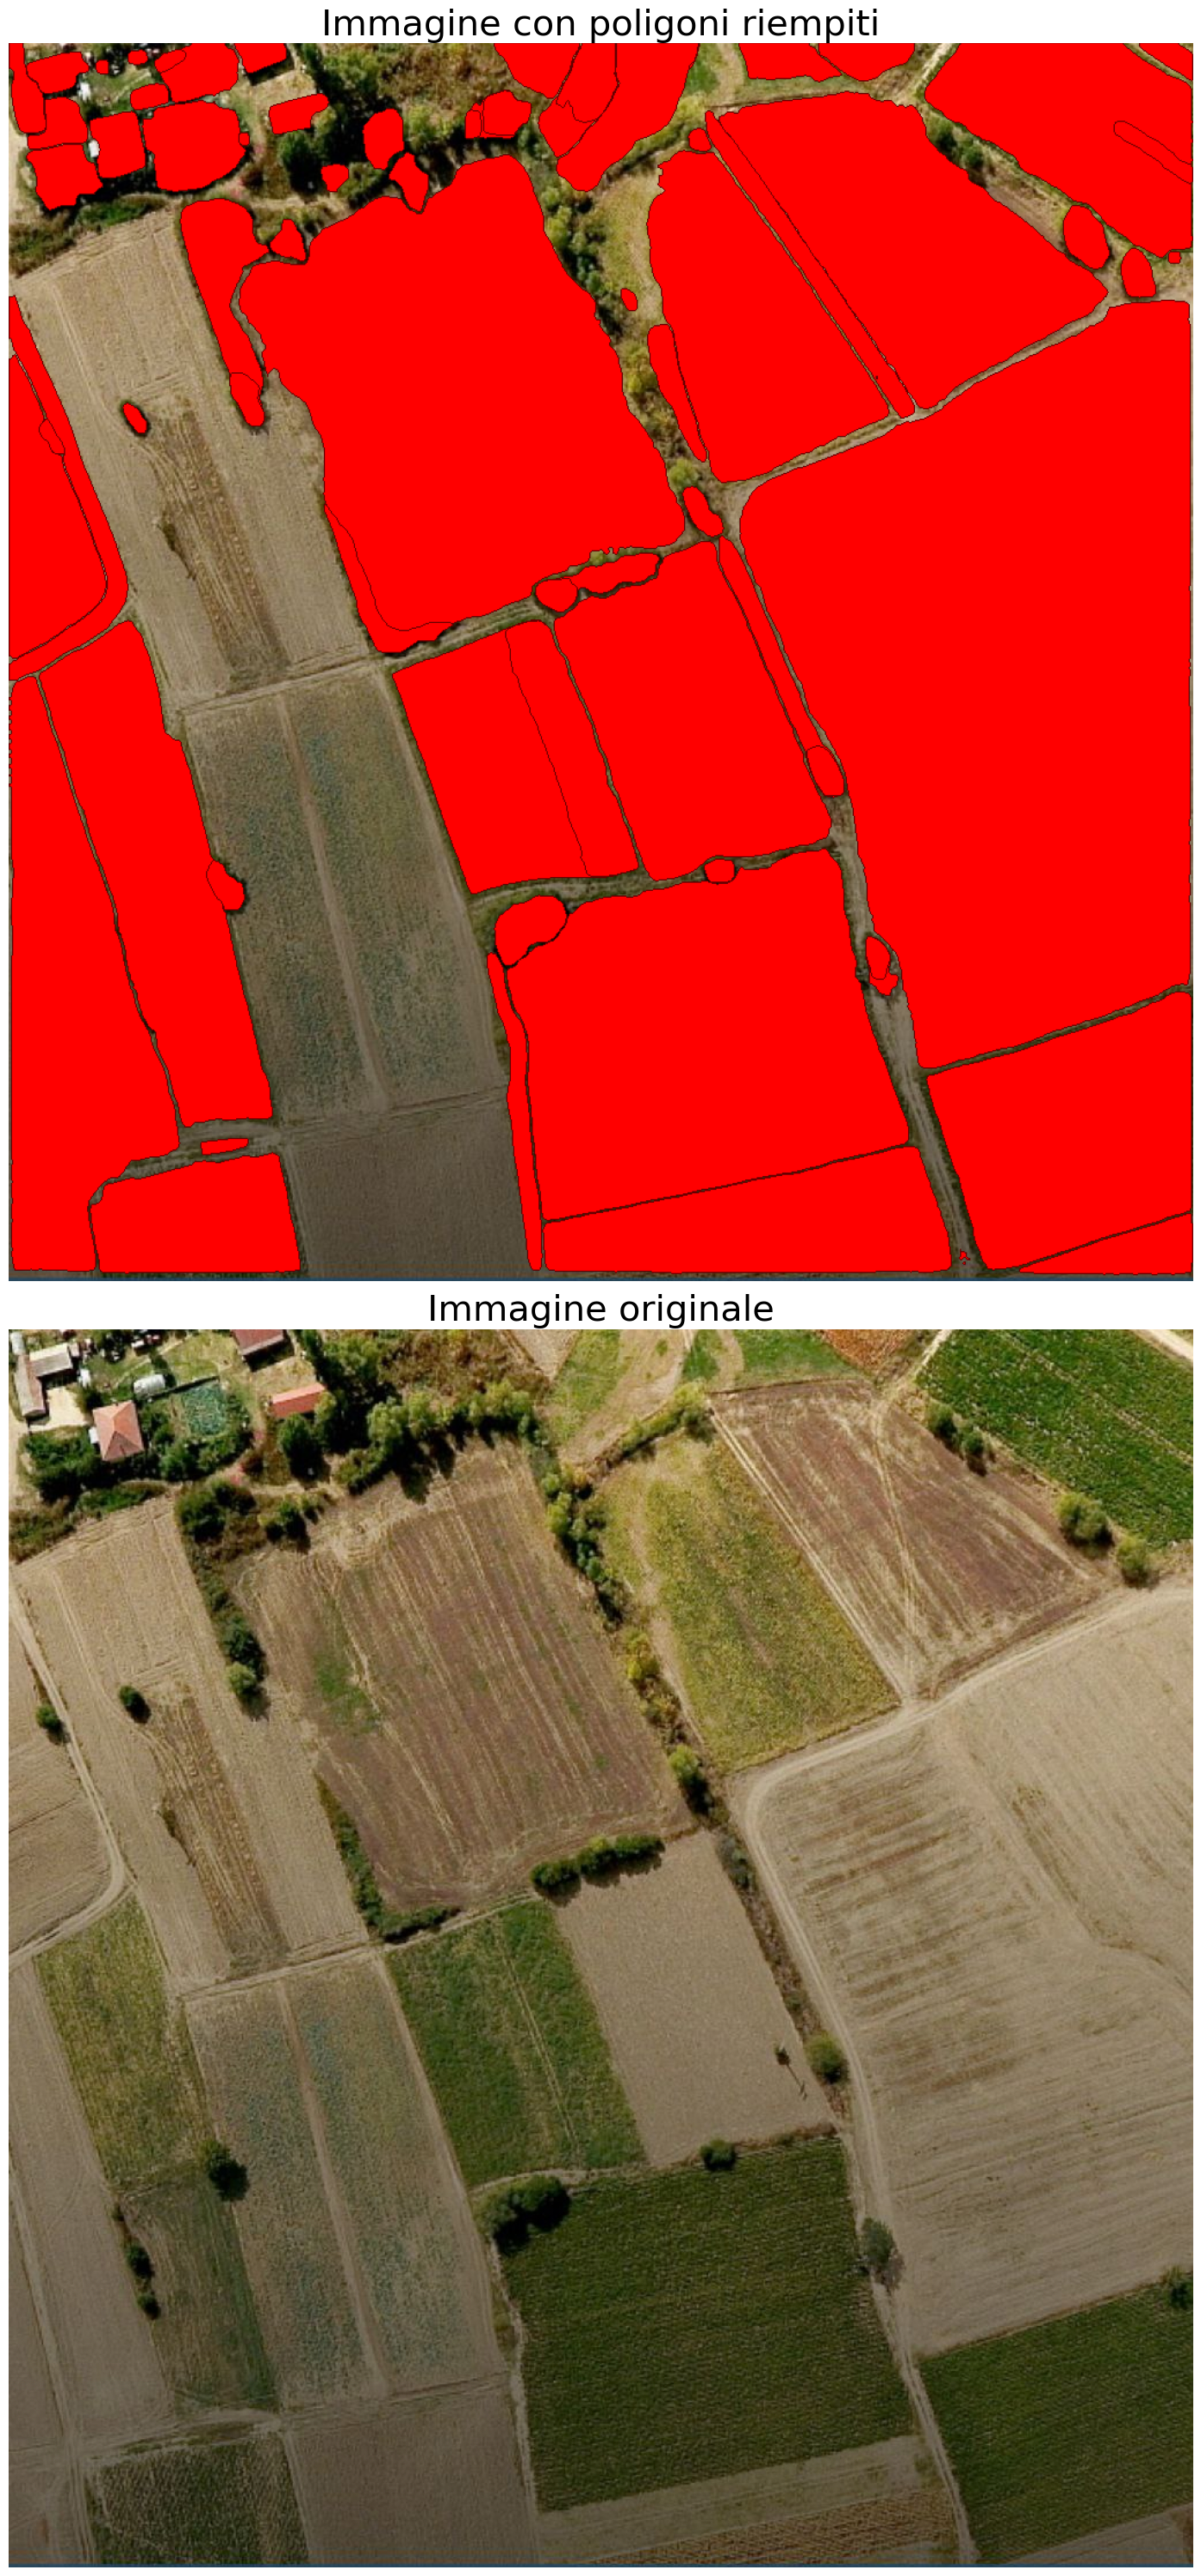

In [18]:
def plot_geojson_filled_contours(image_path, geojson_path='results_json/output_masks.geojson'):
    # 1. Carica l'immagine originale
    image = cv2.imread(image_path)
    image_original = image.copy()  # Copia per il confronto

    # 2. Carica il file GeoJSON
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)
    
    # 3. Crea una nuova immagine dove verranno colorati internamente i contorni (poligoni riempiti)
    image_with_filled_contours = image.copy()

    # 4. Estrai i contorni dai poligoni GeoJSON e colorali internamente
    for feature in geojson_data['features']:
        if feature['geometry']['type'] == 'Polygon':
            for polygon in feature['geometry']['coordinates']:
                # Converti le coordinate del poligono in pixel
                contour = np.array(polygon, dtype=np.int32)

                # Riempie i poligoni con un colore verde
                cv2.fillPoly(image_with_filled_contours, [contour], color=(0, 0, 255))  # Rosso riempito
                # Disegna anche il bordo del poligono (rosso scuro) per differenziarlo
                cv2.polylines(image_with_filled_contours, [contour], isClosed=True, color=(0, 0, 100), thickness=1)
    
    # 5. Converti le immagini BGR in RGB per la visualizzazione con matplotlib
    image_rgb_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
    image_rgb_filled_contours = cv2.cvtColor(image_with_filled_contours, cv2.COLOR_BGR2RGB)

    # 6. Visualizza le immagini con i poligoni riempiti sopra e l'immagine originale sotto
    fig, ax = plt.subplots(2, 1, figsize=(30, 30))  # 2 righe, 1 colonna

    # Mostra l'immagine con i contorni colorati internamente
    ax[0].imshow(image_rgb_filled_contours)
    ax[0].axis('off')  # Nasconde gli assi
    ax[0].set_title('Immagine con poligoni riempiti',fontsize = 30)

    # Mostra l'immagine originale per confronto
    ax[1].imshow(image_rgb_original)
    ax[1].axis('off')  # Nasconde gli assi
    ax[1].set_title('Immagine originale',fontsize = 30)

    # Mostra le immagini
    plt.tight_layout()
    plt.show()

# Esegui la funzione per plottare i contorni colorati e l'immagine originale
plot_geojson_filled_contours(file_path_image)


## Crea il geojson invertendo le coordinate y

In [19]:
def masks_to_geojson(masks, SAVE=True, output_geojson_path="results_json/output_masks.geojson", image_height=None):
    features = []

    # Itera su ogni maschera in masks
    for mask in masks:
        # Estrai l'array di segmentazione dalla maschera
        mask_array = mask['segmentation']
        
        # Assicurati che la maschera sia binaria (0 e 255)
        mask_array = mask_array.astype(np.uint8) * 255
        
        # Trova i contorni della maschera
        contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Itera su ogni contorno trovato
        for contour in contours:
            # Inverti le coordinate Y
            contour_list = contour[:, 0, :].tolist()  # Converti le coordinate del contorno in una lista
            if image_height is not None:  # Se l'altezza dell'immagine è fornita
                # Inverti le coordinate Y
                contour_list = [(x, image_height - y) for x, y in contour_list]
                
            if len(contour_list) >= 3:  # I poligoni devono avere almeno 3 punti
                polygon = Polygon(contour_list)
                
                # Crea una feature GeoJSON per il poligono
                feature = geojson.Feature(geometry=mapping(polygon), properties={})
                features.append(feature)

    # Crea la FeatureCollection GeoJSON
    feature_collection = geojson.FeatureCollection(features)

    # Salva il GeoJSON in un file
    if SAVE:
        with open(output_geojson_path, "w") as f:
            json.dump(feature_collection, f, indent=4)

        print(f"GeoJSON salvato in: {output_geojson_path}")

# Specifica il percorso in cui salvare il file GeoJSON
output_geojson_path = "results_json/output_masks.geojson"

# Specifica l'altezza dell'immagine
image = cv2.imread(file_path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height = image.shape[0]  # Sostituisci con l'altezza reale dell'immagine

# Esegui la conversione e salva il GeoJSON
masks_to_geojson(masks, output_geojson_path, image_height=image_height)


GeoJSON salvato in: results_json/output_masks.geojson
